In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from cryo_sbi import CryoEmSimulator
import cryo_sbi.inference.train_npe_model as train_npe_model
import cryo_sbi.utils.estimator_utils as est_utils
import cryo_sbi.utils.image_utils as img_utils

import umap

### Make the models 

Here we are creating a simple molecular model. 
In our model we will have two pseudo atoms with an unknown distance between them. 
The goal is then to simulate cryo-EM images with these models and infer the distance between the two atoms from the images.

The first step is to create the model. We start by crating an array with the distances `distance_centers` between the atoms. We will use this array to create the models.
The models are then created by placing the atom centers along the y-axis at the given distances. The x and z coordinates are set to zero.

The models are saved into teh file `models.pt`.



In [2]:
distance_centers = torch.linspace(0, 40, 100) # Distance between atoms in Angstrom

In [3]:
models = torch.tensor(
    [[[0.0, 0.0], [-dist/2, dist/2], [0.0, 0.0]] for dist in distance_centers] # creating models from distance_centers
)
torch.save(models, "models.pt") # saving models

##### Visualize the models

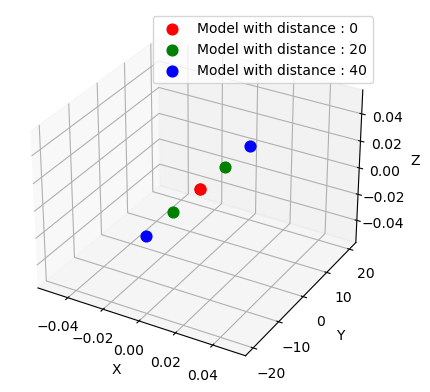

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, c in zip([0, 50, 99], ['r', 'g', 'b']):
    ax.scatter(models[i, 0, 0], models[i, 1, 0], models[i, 2, 0], s=60, color=c, label=f"Model with distance : {distance_centers[i]:.0f}")
    ax.scatter(models[i, 0, 1], models[i, 1, 1], models[i, 2, 1], s=60, color=c)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()

### Run first simulation

```
simulation_parameters.json

{
    "N_PIXELS": 64,             --> size of the image
    "PIXEL_SIZE": 2.0,          --> pixel size in angstroms
    "SIGMA": [2.0, 2.0],        --> standard deviation of the gaussian
    "MODEL_FILE": "models.pt",  --> file which contains the models
    "SHIFT": 0.0,               --> shift of model center 
    "DEFOCUS": [2.0, 2.0],      --> defocus values
    "SNR": [0.01, 0.5],         --> signal to noise ratio 
    "AMP": 0.1,                 --> amplitude of the model 
    "B_FACTOR": [1.0, 1.0]      --> b factor
} 
```

In [ ]:
simulator = CryoEmSimulator("simulation_parameters.json")

In [ ]:
images, parameters = simulator.simulate(num_sim=5000, return_parameters=True)

In [ ]:
dist = parameters[0]
snr = parameters[-1]

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(images[idx], vmin=-3, vmax=3, cmap="gray")
    ax.set_title(f"Distance: {distance_centers[dist[idx].round().long()].item():.2f}")
    ax.axis("off")

### Train cryoSBI posterior

```
train_config.json
```

```
{
    "EMBEDDING": "ConvEncoder64x64",        --> embedding network for the images
    "OUT_DIM": 128,                         --> dimension of the embedding
    "NUM_TRANSFORM": 5,                     --> number of transformations
    "NUM_HIDDEN_FLOW": 5,                   --> number of hidden layers in the flow
    "HIDDEN_DIM_FLOW": 128,                 --> dimension of the hidden layers in the flow
    "MODEL": "NSF",                         --> type of flow
    "LEARNING_RATE": 0.0003,                --> learning rate
    "CLIP_GRADIENT": 5.0,                   --> gradient clipping
    "THETA_SHIFT": 50,                      --> shift of the model center
    "THETA_SCALE": 50,                      --> scale of the model
    "BATCH_SIZE": 32                        --> batch size
}
```


In [ ]:
train_npe_model.npe_train_no_saving(
    "simulation_parameters.json",
    "train_config.json",
    100,
    "tutorial_estimator.pt",
    "tutorial.loss",
    n_workers=4,
    device="cuda",
    saving_frequency=100,
    simulation_batch_size=160,
)

In [ ]:
plt.plot(torch.load("tutorial.loss"))

### Evaluate posterior

In [ ]:
posterior = est_utils.load_estimator(
    "train_config.json",
    "tutorial_estimator.pt",
    device="cuda",
)

In [ ]:
samples = est_utils.sample_posterior(
    estimator=posterior,
    images=images,
    num_samples=15000,
    batch_size=1000,
    device="cuda",
)

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, idx].flatten(), bins=np.linspace(0, simulator.max_index, 60))
    ax.axvline(dist[idx], ymax=1, ymin=0, color="red")
    ax.set_yticks([])

### Plot latent space

In [ ]:
latent_representations = est_utils.compute_latent_repr(
    estimator=posterior,
    images=images,
    batch_size=1000,
    device="cuda",
)

In [ ]:
reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=50)
latent_vecs_transformed = reducer.fit_transform(latent_representations.numpy())

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

scatter = axes.scatter(
    latent_vecs_transformed[:, 0],
    latent_vecs_transformed[:, 1],
    c=dist,
    s=0.5,
    cmap="rainbow",
    # vmin=0,
    # vmax=70,
)

cbar = plt.colorbar(mappable=scatter)
cbar.set_label("Posterior mean", rotation=270, fontsize=15, labelpad=20)


axes.set_xlabel("UMAP 1", fontsize=15)
axes.set_ylabel("UMAP 2", fontsize=15)

axes.set_xticks([])
axes.set_yticks([])